# Mobbing Spy - a tool to monitor mobbing in the enterprises
## Brought to you by Snakey Snakes, January 2022

In this notebook we will present to you the *Mobbing Spy*. A tool to keep the employees safe and sound at the workplace. Keep in mind that this is just an Proof of Concept (PoC) that may be extended for future purposes. 

We will use vector methods and neural networks to solve the problem.*kursywa*

# Introductory steps

## Loading the data

First, we uploaded the data to Google Drive and mounted the colab notebook to Drive. We will extract data from the csvs from Drive and see the contents of directory.

The directory that we have created on my Google Drive is "snakey snakes"

In [153]:
# changing active directory
import os
os.chdir("/content/drive/MyDrive/snakey snakes")

In [154]:
# printing contents of the extracted directory
print(os.listdir(os.getcwd() + "/data"))

['suspicious communication.csv', 'suspicious tweets.csv', 'train.csv', 'labeled_data.csv', 'attack_parsed_dataset.csv', 'toxicity_parsed_dataset.csv', 'aggression_parsed_dataset.csv']


In [155]:
# printing first row (header) from training sets to understend the structure
with open("data/toxicity_parsed_dataset.csv") as f:
    print(f.readline())

index,Text,ed_label_0,ed_label_1,oh_label



The data contains 5 columns. The ones that interest us is the second one (Text) and the last one (oh_label). Text is the document that we are analysing. Oh_label is the label that we are predicting (1 - suspicious, 0 - nonsuspicious)

We are kind of worried about the dataset. It is kind of low-quality (here we would like to remind the basic ML law: SISO, shit in shit out) and the results may be not that great. Nevertheless, this is the best that we could find for this PoC. But no worries - we will manage it!

## Building pandas data frames

For data processing we have decided to use pandas to handle data. Pandas is not a speed demon but this dataset is not that huge.

In the next few cells, we will load  files to pandas data frames and transform them to result in a training and test data frame for further analysis.

In [156]:
# importing pandas
import pandas as pd

In [157]:
train_ = pd.read_csv("data/toxicity_parsed_dataset.csv", encoding='latin1')
train_ = pd.concat([train_, pd.read_csv("data/aggression_parsed_dataset.csv", encoding='latin1')], ignore_index = True)
train_ = pd.concat([train_, pd.read_csv("data/attack_parsed_dataset.csv", encoding='latin1')], ignore_index = True)
train_

,index,Text,ed_label_0,ed_label_1,oh_label
0,0,This: :One can make an analogy in mathematical...,0.900000,0.100000,0
1,1,` :Clarification for you (and Zundark's righ...,1.000000,0.000000,0
2,2,Elected or Electoral? JHK,1.000000,0.000000,0
3,3,`This is such a fun entry. Devotchka I once...,1.000000,0.000000,0
4,4,Please relate the ozone hole to increases in c...,0.800000,0.200000,0
...,...,...,...,...,...
391409,115859,` These sources don't exactly exude a sense ...,0.888889,0.111111,0
391410,115860,The Institute for Historical Review is a pee...,0.900000,0.100000,0
391411,115861,:The way you're trying to describe it in this...,1.000000,0.000000,0
391412,115862,== Warning == There is clearly a protection...,0.800000,0.200000,0


In [158]:
print("How many suspicious examples: {}".format(train_["oh_label"].sum()))

How many suspicious examples: 43734


In [159]:
# preliminary data cleaning
train_['Text'] = train_['Text'].str.replace('http\S+|www.\S+|@\S+', '', case=False) #remove mentions and urls
train = train_.loc[:,["Text", "oh_label"]]
train.columns = ["text", "suspicious"]

In [160]:
# shuffling the dataset
from sklearn.utils import shuffle
train = shuffle(train)
train.head()
train

,text,suspicious
317688,` :Please respond to my comment on Talk:Colle...,0
154612,` == A barnstar for you! you are just amazing ...,0
286925,` == Border Guard == Hi there! Regarding you...,0
115926,== Really?? == you really classify yourself...,1
52880,== Urrrppp == You wanna have my love? Burp!...,0
...,...,...
303545,:Theres one on my userpage,0
225361,:::::Update. Just had chat with Niall who has...,0
30054,== lol === Blocked! yeppers! I basically mad...,0
335239,oh yea school ova and time to get ma dick lic...,1


Next we will spilt train to train and test

In [161]:
# building cumulative test data frame
from sklearn.model_selection import train_test_split
train, test = train_test_split(train, shuffle=False, test_size=0.1)
display(test.head())
print("Test length is {}".format(len(test)))
display(train.head())
print("Train length is {}".format(len(train)))

,text,suspicious
124582,I know i don't know what happened ( ( ( ( (,0
102294,"`== Square Rools, ok? ==== (For the non-Britis...",0
305844,== I'm going to punch you in the ovaries == ...,1
235183,REDIRECT Talk:List of Red Star Belgrade seasons,0
27767,` :Bad idea.It creates a potential for POV for...,0


Test length is 39142


,text,suspicious
317688,` :Please respond to my comment on Talk:Colle...,0
154612,` == A barnstar for you! you are just amazing ...,0
286925,` == Border Guard == Hi there! Regarding you...,0
115926,== Really?? == you really classify yourself...,1
52880,== Urrrppp == You wanna have my love? Burp!...,0


Train length is 352272


In [162]:
print("Number of suspicious in test set is {}".format(test["suspicious"].sum()))
print("Number of nonsuspicious in test set is {}".format(len(test)-test["suspicious"].sum()))
print("Number of suspicious in train set is {}".format(train["suspicious"].sum()))
print("Number of nonsuspicious in train set is {}".format(len(train)-train["suspicious"].sum()))

Number of suspicious in test set is 4388
Number of nonsuspicious in test set is 34754
Number of suspicious in train set is 39346
Number of nonsuspicious in train set is 312926


# Explorative Data Analysis & Preprocessing

## Preliminary Data Exploration

In [163]:
# for visualizations we will be using matplotlib
import matplotlib.pyplot as plt

In the preliminary data exploration step, we will draw a histogram of documents' lengths.

Probably other preliminary EDA could be performed (e.g., language diversity or language detection), but this is just a concept, so we will not dive too deep into the analysis

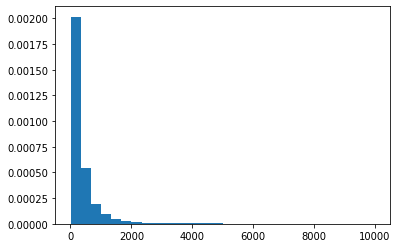

In [164]:
# plotting the histogram of documents' lengths
lengths = train["text"].apply(lambda x: len(x)).values
plt.hist(lengths, density=True, bins=30)
plt.show()

From the histogram we can see that the lengths of the documents are very uneven - this may cause problems to our dataset. There is a big chunk of documents that seem to be super short

In [165]:
# checking out too short documents
print(train["text"].str.len().nsmallest(10))
print(train.loc[train["text"].str.len() <=3, "text"])

298465    3
30068     3
182601    3
31433     3
130694    3
131187    4
262610    5
121843    5
364132    5
358192    5
Name: text, dtype: int64
298465       
30068        
182601       
31433        
130694       
Name: text, dtype: object


In [166]:
# The documents shorter than 4 characters do not bring information to the data
# thus we decided to remove them
train = train.loc[train["text"].str.len()>3, :]

At this step it could be useful to perform other steps (like language detection, word lengths analysis, language diversity, etc). We won't do that in this PoC as it takes too much computational power to do so.

## Preprocessing

We will preprocess the data on the basic level for the later analysis. Ideally we would start the preprocessing with translating non English documents.

We are going to:

*   trasform  documents to lowercase,
*   remove cotractions (n't),
*   remove special characters,
*   remove stopwords,
*   remove custom stop words (stopwords specific to this dataset)
*   and lemmatize


*In the real life example the number of transformations combinations and propositions would probably be much bigger but this is just a PoC so we will perform preprocessing only once*

In [167]:
# the main preprocessing pipeline
import re
import nltk
import string
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

def contractions(s):
 s = re.sub(r"won't", "will not",s)
 s = re.sub(r"would't", "would not",s)
 s = re.sub(r"could't", "could not",s)
 s = re.sub(r"\'d", " would",s)
 s = re.sub(r"can\'t", "can not",s)
 s = re.sub(r"n\'t", " not", s)
 s = re.sub(r"\'re", " are", s)
 s = re.sub(r"\'s", " is", s)
 s = re.sub(r"\'ll", " will", s)
 s = re.sub(r"\'t", " not", s)
 s = re.sub(r"\'ve", " have", s)
 s = re.sub(r"\'m", " am", s)
 return s

def preprocess(data):
  # transforming to lowercase
  data['clean'] = data['text'].apply(lambda x: x.lower())
  # removing contractions
  data['clean'] = data["clean"].apply(lambda x: contractions(x))
  # removing punctuation
  data['clean'] = data['clean'].apply(lambda x: ' '.join(''.join(' ' if c in string.punctuation else c for c in x).split()))
  # removing multiple spaces
  data['clean'] = data['clean'].apply(lambda x: re.sub(' +', ' ', x))
  # removing stopwords
  stop = stopwords.words('english') # common
  stop.extend(["wikipedia", "wiki", "article", "page", "en", "org"]) #custom
  data['clean'] = data['clean'].apply(lambda x: ' '.join([x for x in x.split() if x not in stop]))
  # lemmatize
  lemmatizer = WordNetLemmatizer()
  data['clean'] = data['clean'].apply(lambda x: ' '.join([lemmatizer.lemmatize(w) for w in nltk.word_tokenize(x)]))
  
  return data

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [168]:
# running the preprocessing
%%time
train = preprocess(train)
test = preprocess(test)

CPU times: user 4min 16s, sys: 1.02 s, total: 4min 17s
Wall time: 4min 17s


In [169]:
# results
train.head()

,text,suspicious,clean
317688,` :Please respond to my comment on Talk:Colle...,0,please respond comment talk collectonian reque...
154612,` == A barnstar for you! you are just amazing ...,0,barnstar amazing staking retired style backgro...
286925,` == Border Guard == Hi there! Regarding you...,0,border guard hi regarding edit comment deleted...
115926,== Really?? == you really classify yourself...,1,really really classify macedonian wish alexand...
52880,== Urrrppp == You wanna have my love? Burp!...,0,urrrppp wan na love burp


In [170]:
# dump of preprocessed data for the future
train.to_csv("train_preprocessed.csv")
test.to_csv("test_preprocessed.csv")

In [42]:
# reading the data from file
train = pd.read_csv("train_preprocessed.csv", index_col=0)
test = pd.read_csv("test_preprocessed.csv", index_col=0)

## Data Exploration continued

After data preprocessing step we decided to explore the contents of the documents a little bit to better understand the dataset.

First we will draw a word cloud and word frequency bar chart to get a basic look at the contents.

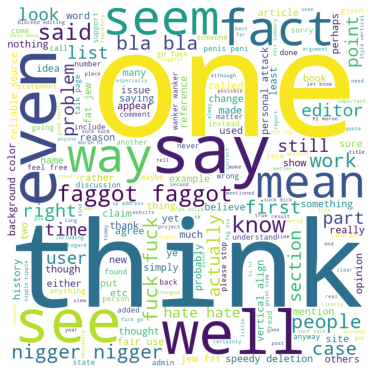

In [176]:
# drawing word cloud
from wordcloud import WordCloud
wordcloud = WordCloud(width = 800, height = 800,
                background_color ='white',
                min_font_size = 10)\
                .generate(' '.join(train['clean'].astype(str)[10000:])) 
                #using only sample because we don't have that much 
                #time to wait for wordcloud to generate for this many documents:)
 
# plot the WordCloud image                      
plt.figure(figsize = (5, 5), facecolor = None)
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad = 0)
 
plt.show()

In [177]:
# praparing data for the word frequency diagram
from collections import Counter
import numpy as np
terms = (' '.join(train['clean'].astype(str))).split()
counts = dict(Counter(terms).most_common(30)) #take only top 30 words
print(counts)
labels, values = zip(*counts.items())

{'would': 78916, 'one': 68896, 'like': 65872, 'please': 60430, 'talk': 50520, 'source': 47109, 'see': 46809, 'think': 46482, 'know': 46387, 'also': 45352, 'people': 44772, 'time': 43377, 'edit': 38829, 'make': 36092, 'fuck': 36035, 'article': 34479, 'get': 34298, 'user': 33698, 'use': 33321, 'say': 32933, 'even': 31413, 'may': 31197, 'need': 30406, 'name': 30261, 'u': 29406, 'go': 29150, 'want': 28631, 'well': 28294, 'good': 28239, 'could': 28120}


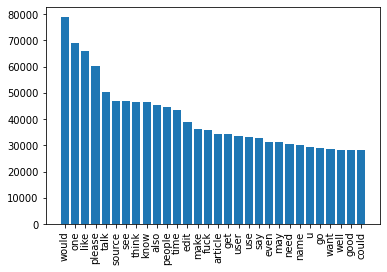

In [178]:
# plotting word frequencies
plt.bar(labels, values)
plt.xticks(rotation=90)
plt.show()

There are no strcitly "too common" words. 

We see that we can remove some more custom stop words - e.g. would, get, u, also. These would probably improve our algorithm. We will not do it here, this is just PoC, in the real analysis removing this words would be worth checking out.

Next, we will proceed with drawing the bigrams to know the dataset even better

In [179]:
# preparing data for the bigrams frequencies chart
bigrams = [bigram for document in train['clean'].astype(str)\
           for bigram in zip(document.split(" ")[:-1], document.split(" ")[1:])]
counts_bi = dict(Counter(bigrams).most_common(30)) #take only top 30 words
print(counts_bi)
labels_bi, values_bi = zip(*counts_bi.items())
labels_bi = [' '.join(bigram) for bigram in labels_bi]

{('faggot', 'faggot'): 10389, ('nigger', 'nigger'): 10044, ('bla', 'bla'): 9995, ('would', 'like'): 9886, ('fuck', 'fuck'): 9287, ('hate', 'hate'): 7422, ('speedy', 'deletion'): 7194, ('personal', 'attack'): 7112, ('can', 'not'): 7082, ('reliable', 'source'): 6799, ('jew', 'fat'): 6182, ('fat', 'jew'): 6142, ('as', 'as'): 5719, ('background', 'color'): 5670, ('vertical', 'align'): 5635, ('fair', 'use'): 5474, ('penis', 'penis'): 4673, ('talk', 'page'): 4494, ('go', 'fuck'): 4479, ('please', 'stop'): 4479, ('feel', 'free'): 4434, ('wanker', 'wanker'): 4275, ('blocked', 'editing'): 4177, ('desu', 'desu'): 3982, ('hi', 'hi'): 3726, ('fuck', 'go'): 3684, ('ip', 'address'): 3665, ('nipple', 'nipple'): 3665, ('style', 'vertical'): 3611, ('look', 'like'): 3579}


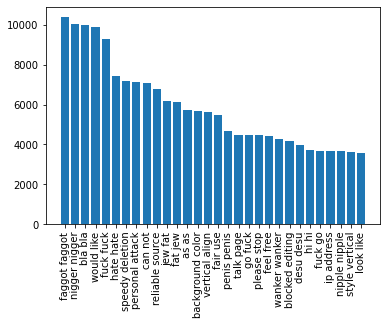

In [180]:
# drawing the bigrams frequencies chart
plt.bar(labels_bi, values_bi)
plt.xticks(rotation=90)
plt.show()

With bigrams we can observe the contents of the dataset in greater context. The most common bigrams are of course offensive words :) we love the internet users

# Basic Classification Methods

Our first go is to use vector/reggresion-like methods to solve this NLP problem. Vectors are much less computionally expensive than neural networks and in many cases they work really well. We want to give it a go and see what happens.

## Building self-designed models

Finally we can start building the models :). First, we are building train and test feature vectors based on TF-IDF matrix. The class to be predicted is the "suspicious" column. 

In [183]:
# setting the training and testing vectors
X_train_sentences, X_test_sentences, Y_train, Y_test = train['clean'].astype(str), test['clean'].astype(str), train['suspicious'], test['suspicious']
# building tf-idf feautre matrix
from sklearn.feature_extraction.text import TfidfVectorizer
vectorizer = TfidfVectorizer()
X_train = vectorizer.fit_transform(X_train_sentences)
X_test = vectorizer.transform(X_test_sentences)

In [184]:
# saving the vectorizer for the API
with open('vectorizer.pkl', 'wb') as fid:
    cPickle.dump(vectorizer, fid)

We will try to build different models to predict the offensive documents. The assessment of results will be provided by the sklearn classification_report function. In the end of this analysis we will perform a comparison of the outcomes.

In [185]:
# evaluation dictionary
from sklearn.metrics import classification_report
import _pickle as cPickle
results = {}

### SVM algorithm

In [186]:
%%time
# building and testing svm model
from sklearn.svm import LinearSVC
svm_model = LinearSVC(random_state = 0)
svm_model.fit(X_train, Y_train)
y_test_pred = svm_model.predict(X_test)

CPU times: user 4.48 s, sys: 20.8 ms, total: 4.5 s
Wall time: 4.5 s


In [187]:
# save the classifier
with open('svm_classifier.pkl', 'wb') as fid:
    cPickle.dump(svm_model, fid)    

In [188]:
# testing the results
results["svm"] = classification_report(Y_test, y_test_pred, output_dict = True)
results["svm"]

{'0': {'f1-score': 0.978715512568119,
  'precision': 0.9705466274332277,
  'recall': 0.9870230764804051,
  'support': 34754},
 '1': {'f1-score': 0.8177376007818224,
  'precision': 0.8812532912058978,
  'recall': 0.7627620783956244,
  'support': 4388},
 'accuracy': 0.9618823769863574,
 'macro avg': {'f1-score': 0.8982265566749708,
  'precision': 0.9258999593195627,
  'recall': 0.8748925774380147,
  'support': 39142},
 'weighted avg': {'f1-score': 0.9606691409744786,
  'precision': 0.960536429707881,
  'recall': 0.9618823769863574,
  'support': 39142}}

### Logistic regression

In [189]:
%%time
# building and testing logistic reggression model

from sklearn.linear_model import LogisticRegression
lr_model = LogisticRegression(max_iter = 1000, solver='saga')
lr_model.fit(X_train, Y_train)
y_test_pred = lr_model.predict(X_test)

CPU times: user 9.46 s, sys: 18.7 ms, total: 9.47 s
Wall time: 9.45 s


In [190]:
# testing the results
results["lr"] = classification_report(Y_test, y_test_pred,output_dict=True)
results["lr"]

{'0': {'f1-score': 0.973490364631198,
  'precision': 0.9569701181375956,
  'recall': 0.9905910111066352,
  'support': 34754},
 '1': {'f1-score': 0.7518199867637327,
  'precision': 0.8967477107672877,
  'recall': 0.6472196900638104,
  'support': 4388},
 'accuracy': 0.9520974911859383,
 'macro avg': {'f1-score': 0.8626551756974654,
  'precision': 0.9268589144524416,
  'recall': 0.8189053505852228,
  'support': 39142},
 'weighted avg': {'f1-score': 0.9486400856959767,
  'precision': 0.9502189065607494,
  'recall': 0.9520974911859383,
  'support': 39142}}

### Bayes Naive Classifier

In [191]:
%%time
# building and testing naive bayes classifier model

from sklearn.naive_bayes import MultinomialNB
nb_model = MultinomialNB()
nb_model.fit(X_train, Y_train)
y_test_pred = nb_model.predict(X_test)

CPU times: user 161 ms, sys: 4.02 ms, total: 165 ms
Wall time: 163 ms


In [192]:
# testing the results
results["nb"] = classification_report(Y_test, y_test_pred,output_dict=True)
results["nb"]

{'0': {'f1-score': 0.9606460639137844,
  'precision': 0.926222720837674,
  'recall': 0.9977268803590954,
  'support': 34754},
 '1': {'f1-score': 0.533727227966519,
  'precision': 0.9536656891495601,
  'recall': 0.3705560619872379,
  'support': 4388},
 'accuracy': 0.9274181186449338,
 'macro avg': {'f1-score': 0.7471866459401517,
  'precision': 0.9399442049936171,
  'recall': 0.6841414711731666,
  'support': 39142},
 'weighted avg': {'f1-score': 0.9127864795252351,
  'precision': 0.9292992050477951,
  'recall': 0.9274181186449338,
  'support': 39142}}

### Comparison

In [193]:
# printing cumulative results
import json
print(json.dumps(results, indent=4))

{
    "svm": {
        "0": {
            "precision": 0.9705466274332277,
            "recall": 0.9870230764804051,
            "f1-score": 0.978715512568119,
            "support": 34754
        },
        "1": {
            "precision": 0.8812532912058978,
            "recall": 0.7627620783956244,
            "f1-score": 0.8177376007818224,
            "support": 4388
        },
        "accuracy": 0.9618823769863574,
        "macro avg": {
            "precision": 0.9258999593195627,
            "recall": 0.8748925774380147,
            "f1-score": 0.8982265566749708,
            "support": 39142
        },
        "weighted avg": {
            "precision": 0.960536429707881,
            "recall": 0.9618823769863574,
            "f1-score": 0.9606691409744786,
            "support": 39142
        }
    },
    "lr": {
        "0": {
            "precision": 0.9569701181375956,
            "recall": 0.9905910111066352,
            "f1-score": 0.973490364631198,
            "support":

### Conclusions

Naive Bayer Classifier and Logistic Regression are just a no-no for this task. They total missperform and are useless in this task with this dataset.

SVM seems to be an okay option. It does not give superior results but f1 scores oscilating within the 0.9 mark are acceptable for this kind of PoC with such a limited time bounds. We also appreciete the easiness of use of the SVM method and the fact that it trains within seconds (not hours like neural network that will be presented below).

As we are not fully satisfied with the results provided by SVM, in the next part of this paper we will proceed to build a neural network as it may be more useful detecting e.g. sarcasm and other hidden meanings in the text.

For now we think that SVM performed the best and if any, would suggest using SVM for further reseach :)

In [198]:
####HOW TO USE IN THE API####
from sklearn.feature_extraction.text import TfidfVectorizer
import _pickle as cPickle

# the main preprocessing pipeline
import re
import nltk
import string
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

def contractions(s):
 s = re.sub(r"won't", "will not",s)
 s = re.sub(r"would't", "would not",s)
 s = re.sub(r"could't", "could not",s)
 s = re.sub(r"\'d", " would",s)
 s = re.sub(r"can\'t", "can not",s)
 s = re.sub(r"n\'t", " not", s)
 s = re.sub(r"\'re", " are", s)
 s = re.sub(r"\'s", " is", s)
 s = re.sub(r"\'ll", " will", s)
 s = re.sub(r"\'t", " not", s)
 s = re.sub(r"\'ve", " have", s)
 s = re.sub(r"\'m", " am", s)
 return s

def preprocess(sentence):
  sentence = contractions(sentence.lower())
  sentence = ' '.join(''.join(' ' if c in string.punctuation else c for c in sentence).split())
  sentence = re.sub(' +', ' ', sentence)
  stop = stopwords.words('english')
  sentence =  ' '.join([sentence for sentence in sentence.split() if sentence not in stop])
  lemmatizer = WordNetLemmatizer()
  sentence = ' '.join([lemmatizer.lemmatize(w) for w in nltk.word_tokenize(sentence)])
  return sentence

with open('vectorizer.pkl', 'rb') as fid:
    vectorizer = cPickle.load(fid)
with open('svm_classifier.pkl', 'rb') as fid:
    svm_model = cPickle.load(fid)
sentence = "i can't believe how stupid u are"
sentence = preprocess(sentence)
X_test_ = vectorizer.transform([sentence])
y_test_pred_ = svm_model.predict(X_test_)
print("prediction: {}".format(y_test_pred_[0]))

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
prediction: 1


# Neural Networks

In [ ]:
######neural network coming soon#######

# That's it :)

This would probably wrap up our analysis for now we guess.

We wanted to do some more cool stuff with the data but we think that this document is getting too long anyways.

Have a nice day :))